In [2]:
import wikipedia as wp
import pandas as pd
import yfinance as yf
import numpy as np
from ta.momentum import rsi
from ta.trend import macd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")

stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})

stocks.head()


,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


In [4]:
stocks.to_csv("../data/stocks.csv")

In [5]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")

fundamentals.index = fundamentals.index.rename("Symbol")
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)

fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3995082424320,36.242626,32.535496,54.171505,7.46,8.31,4.991,0.1367,1.094,0.53,0.217828,54316450,9.738,0.26915
ABBV,385180336128,163.939830,17.975267,-2096.538300,1.33,12.13,-0.104,4.9015,0.507,3.78,0.087644,5337314,7.534,0.04004
ABT,214959357952,15.530151,23.957365,4.218681,7.96,5.16,29.303,0.2915,0.696,1.71,0.050744,5791825,5.030,0.31880
ACN,155096743936,20.584364,17.775410,4.985548,12.15,14.07,50.165,0.4872,1.278,1.45,-0.272754,4930442,2.194,0.11021
ADBE,142453768192,21.229568,16.560099,12.143519,16.03,20.55,28.024,0.0000,1.490,0.12,-0.293009,4365357,6.176,0.30012


In [6]:
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,4.232020,-0.118279,0.001860,0.319914,-0.175282,-0.203437,-0.100801,-0.469082,0.233075,-0.999637,0.092624,1.600044,0.212578,0.724756
ABBV,-0.079928,0.734254,-0.244290,-9.861540,-0.544849,-0.026418,-0.100911,5.132847,-1.079175,1.033417,-0.183186,-0.357023,0.055436,-1.254594
ABT,-0.283253,-0.256560,-0.143159,0.083437,-0.145138,-0.349407,-0.100278,-0.287085,-0.656662,-0.261482,-0.261363,-0.338862,-0.123097,1.153697
ACN,-0.354758,-0.222817,-0.247669,0.087068,0.107470,0.063481,-0.099828,-0.057002,0.644411,-0.424127,-0.946729,-0.373280,-0.325301,-0.648374
ADBE,-0.369860,-0.218509,-0.268214,0.120954,0.341388,0.363763,-0.100305,-0.629799,1.118341,-1.256115,-0.989643,-0.395859,-0.041388,0.992315


In [7]:
normalized_fundamentals.to_csv("../data/fundamentals.csv")

ALR = annualized log return

Relative Strength Index (RSI): momentum indicator that measures the magnitude of recent price changes to evaluate overbought/oversold conditions

Moving Average Convergence Divergence (MACD): trend-following momentum indicator

In [8]:
values = [
	yf.Ticker(stock).history(period="10y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
	stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()

	stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
	stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
	stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
	stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
	stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21

	stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
	stock_values["ALR1W"] /= stock_values["ALR1W"].std()
	stock_values["ALR2W"] /= stock_values["ALR2W"].std()
	stock_values["ALR1M"] /= stock_values["ALR1M"].std()
	stock_values["ALR2M"] /= stock_values["ALR2M"].std()

	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])

	stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)

Close  NormClose  DailyLogReturn  \
Symbol Date                                                              
AAPL   2016-01-04 00:00:00-05:00  23.776175  -1.213590        0.046566   
       2016-01-05 00:00:00-05:00  23.180363  -1.221945       -1.382923   
       2016-01-06 00:00:00-05:00  22.726732  -1.228307       -1.076956   
       2016-01-07 00:00:00-05:00  21.767563  -1.241758       -2.349740   
       2016-01-08 00:00:00-05:00  21.882658  -1.240144        0.287364   
       2016-01-11 00:00:00-05:00  22.236988  -1.235175        0.875280   
       2016-01-12 00:00:00-05:00  22.559727  -1.230649        0.785188   
       2016-01-13 00:00:00-05:00  21.979708  -1.238783       -1.419331   
       2016-01-14 00:00:00-05:00  22.460419  -1.232041        1.178928   
       2016-01-15 00:00:00-05:00  21.921028  -1.239606       -1.324600   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                                                                
AAPL   2016-01-04 00:00:00-05:00 -0.643199 -0.618217 -1.220127 -1.183832   
       2016-01-05 00:00:00-05:00 -1.004595 -0.580557 -1.418475 -1.504688   
       2016-01-06 00:00:00-05:00 -1.966732 -1.163616 -2.067017 -1.636419   
       2016-01-07 00:00:00-05:00 -2.734244 -1.933518 -2.521878 -1.972253   
       2016-01-08 00:00:00-05:00 -2.102981 -2.070642 -2.451468 -1.936345   
       2016-01-11 00:00:00-05:00 -1.713595 -1.679799 -1.977016 -1.760858   
       2016-01-12 00:00:00-05:00 -0.694870 -1.211290 -1.857565 -1.355830   
       2016-01-13 00:00:00-05:00 -0.855741 -2.011710 -1.857215 -1.533586   
       2016-01-14 00:00:00-05:00  0.802266 -1.377013 -1.513115 -1.315523   
       2016-01-15 00:00:00-05:00  0.044856 -1.466923 -1.592932 -1.268983   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2016-01-04 00:00:00-05:00  0.325942 -0.650458  
       2016-01-05 00:00:00-05:00  0.281393 -0.699484  
       2016-01-06 00:00:00-05:00  0.253036 -0.766109  
       2016-01-07 00:00:00-05:00  0.205809 -0.886093  
       2016-01-08 00:00:00-05:00  0.224513 -0.960819  
       2016-01-11 00:00:00-05:00  0.280677 -0.980149  
       2016-01-12 00:00:00-05:00  0.328390 -0.958378  
       2016-01-13 00:00:00-05:00  0.291029 -0.976669  
       2016-01-14 00:00:00-05:00  0.356385 -0.941522  
       2016-01-15 00:00:00-05:00  0.320665 -0.946284

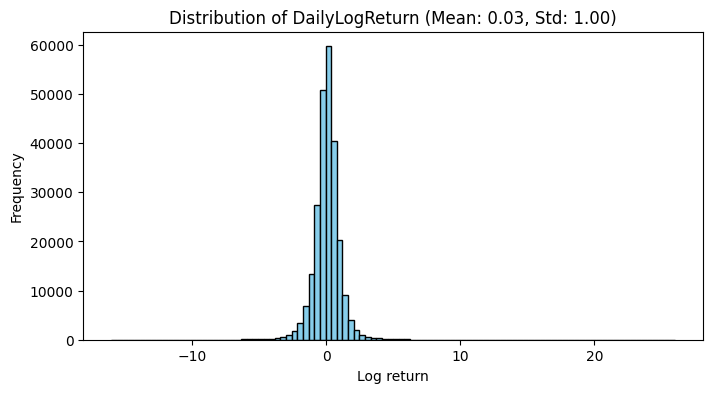

In [9]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

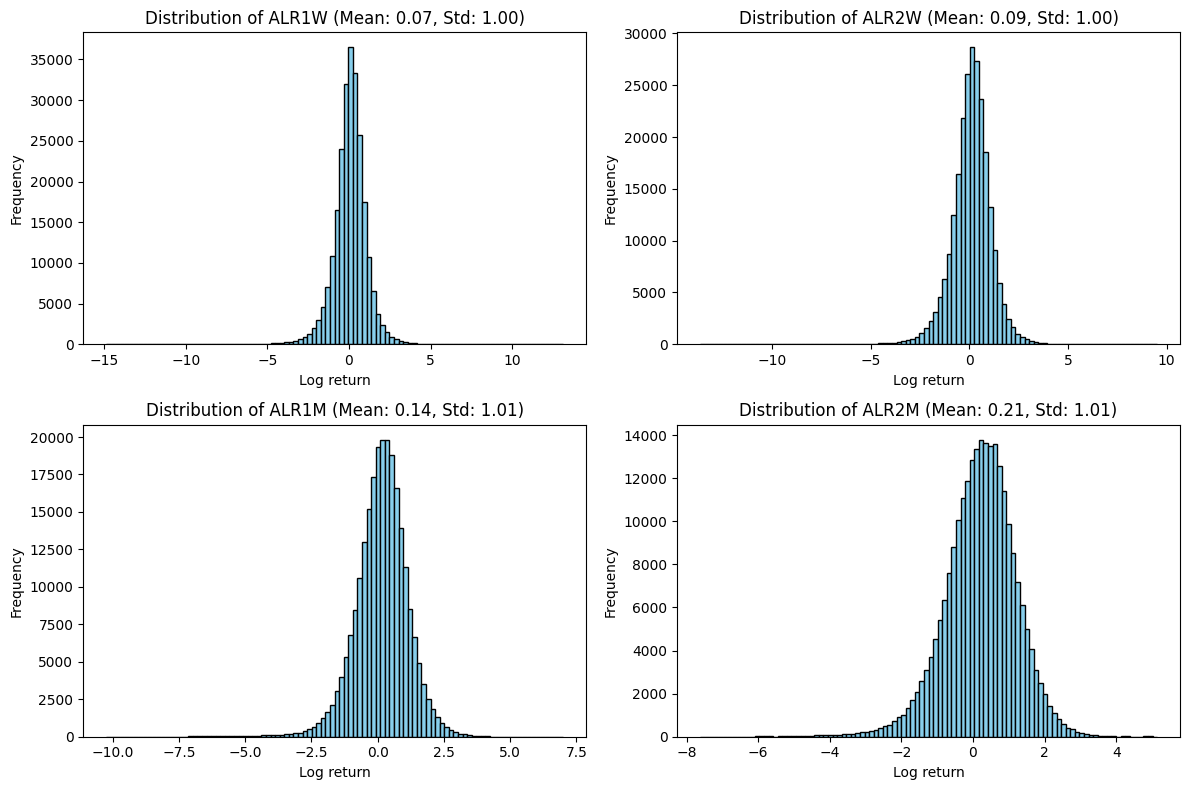

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR1W", "ALR2W", "ALR1M", "ALR2M"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")
	
plt.tight_layout()
plt.show()

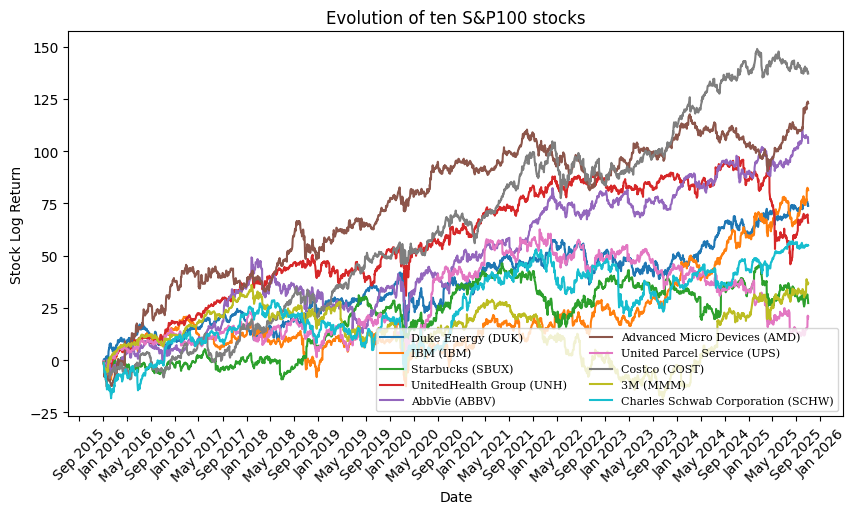

In [11]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

In [12]:
values.to_csv("../data/values.csv")